In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr

In [170]:
# matplotlib rebuild

import matplotlib.pyplot as plt
from matplotlib import font_manager
%matplotlib inline


font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000


In [3]:
df = pd.read_csv('./data/preprocessing/preprocessed/df_tokenized.csv',index_col=0)

#### 사업보고서 fillings_month 체크

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


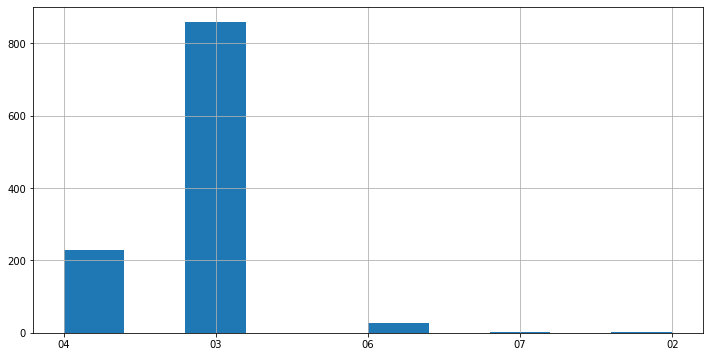

In [4]:
rcp_month = [str(x)[4:6] for x in df.rcp_dt]
rcp_df = pd.DataFrame(rcp_month,columns={'발행월'})
hist = plt.hist(rcp_df.발행월,bins = None)
plt.show()

## wordcount

In [5]:
def word_count(ls):  #document의 word count
    ls = ls.split()
    counts = dict()
    for word in ls:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
            
    return counts


In [6]:
def total_word_count(srs): #total document의 word count
    ls = [x.split() for x in srs]
    counts = dict()
    for doc in ls:
        for word in doc:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    return counts

In [7]:
tokens_dic = total_word_count(df.str_tokens)
nouns_dic = total_word_count(df.str_nouns)
tfd_tokens = pd.DataFrame(tokens_dic.items(),columns = ['단어','빈도']).sort_values('빈도',ascending=False)
tfd_nouns = pd.DataFrame(nouns_dic.items(),columns = ['단어','빈도']).sort_values('빈도',ascending=False)

### Wordcloud

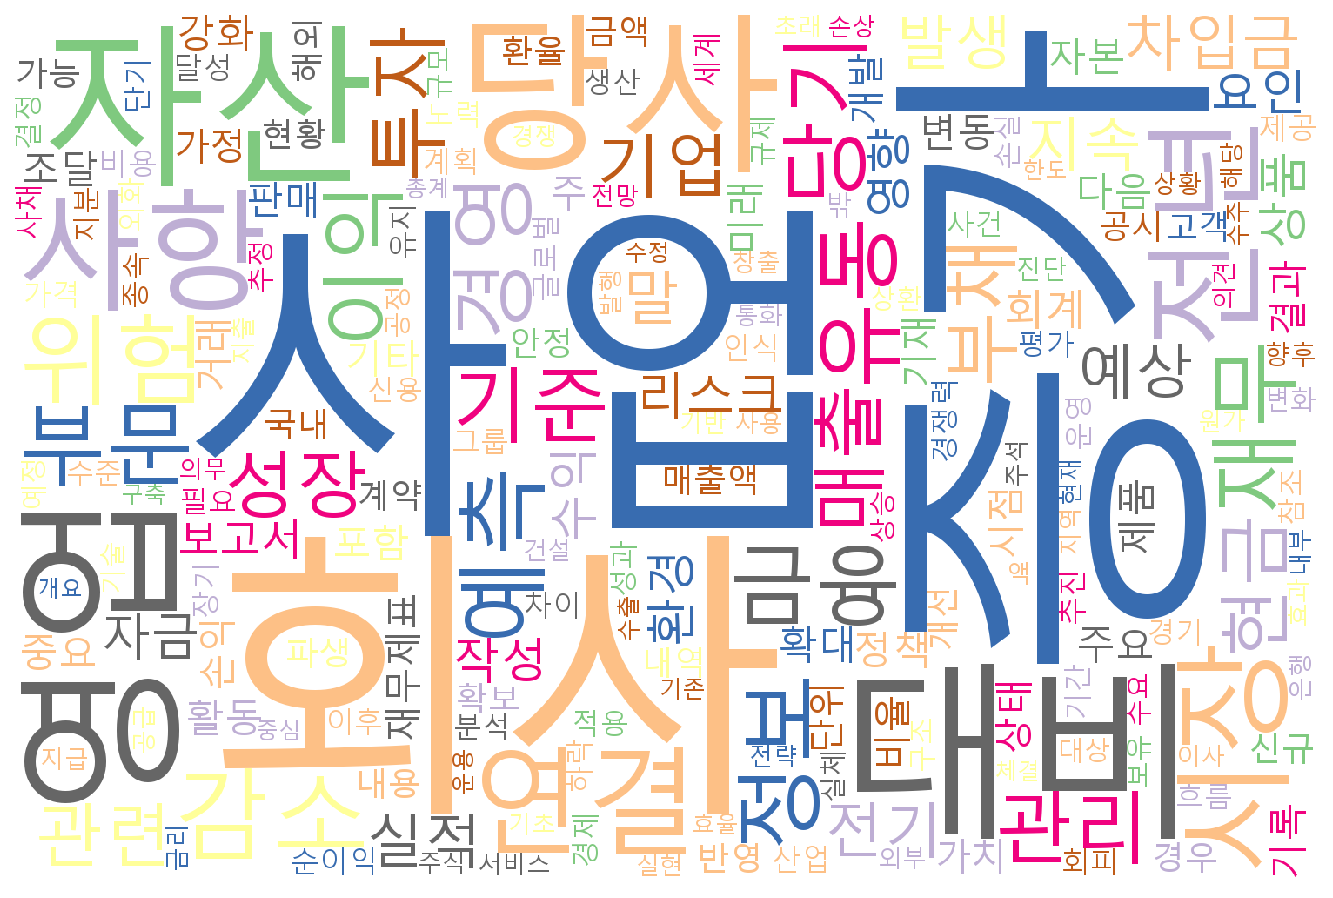

In [171]:
from wordcloud import WordCloud #wordcloud 생성
from IPython.display import set_matplotlib_formats

matplotlib.rc('font',family = 'Malgun Gothic')
set_matplotlib_formats('retina')
matplotlib.rc('axes',unicode_minus = False)
plt.rcParams["figure.figsize"] = (15,8)
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r",
            width=1500, height=1000).generate_from_frequencies(nouns_dic) #여기에 dic형태넣어주기

plt.imshow(wordcloud)
plt.axis('off')
plt.show;

## Document size check

In [8]:
print(df.shape)
print(tfd_tokens.shape)
print(tfd_nouns.shape)

(1117, 9)
(14198, 2)
(9865, 2)


dataset은 10년동안 kospi200에 계속 편입되어있던 113개의 기업의 발간 사업보고서들인 1117개의 Documents입니다.
Mecab으로 형태소분석을 했을 때 총 토큰들과 그 중 명사만 뽑아 term document freqeuncy를 빈도가 높은 순 대로 살펴보았는데 각각 14198, 9865개의 단어 수를 기록했습니다. 형태소분석 단어집합들은 숫자를 치환한 'num'와 조사가 빈도수가 가장 많았습니다.


다음으로는 조사와 num을 제외하여 단어 count를 살펴보고, tfd_nouns와 비교 후 이를 documnet filings 연도별로 매칭시켜 연도별 word counts의 frequency를 살펴보도록 하자.

In [55]:
df_count = df.copy()
df_count = df.count.loc[:,['연도','crp_nm','rpt_nm']]
word_count_ls = [len(word_count(x).items()) for x in df.str_tokens]
word_count_noun_ls = [len(word_count(x).items()) for x in df.str_nouns]
df_count['document_size'] = word_count_ls
df_count['document_noun_size'] = word_count_noun_ls

In [157]:
df_count.document_size.describe()

count    1117.000000
mean      533.700090
std       261.591933
min        26.000000
25%       372.000000
50%       479.000000
75%       629.000000
max      1939.000000
Name: document_size, dtype: float64

In [152]:
df_count = df_count.sort_values(by = '연도')
year_ls = [sum(df_count[df_count.연도 == x].document_size) for x in df.count.연도.unique()]
year_noun_ls = [sum(df_count[df_count.연도 == x].document_noun_size) for x in df.count.연도.unique()]
doc_size_by_year = pd.DataFrame(list(zip(df.count.연도.unique(),year_ls,year_noun_ls)),columns= {'year','document','noun'})
doc_size_by_year = doc_size_by_year.sort_values(by = 'year', ascending= True).reset_index(drop=True)

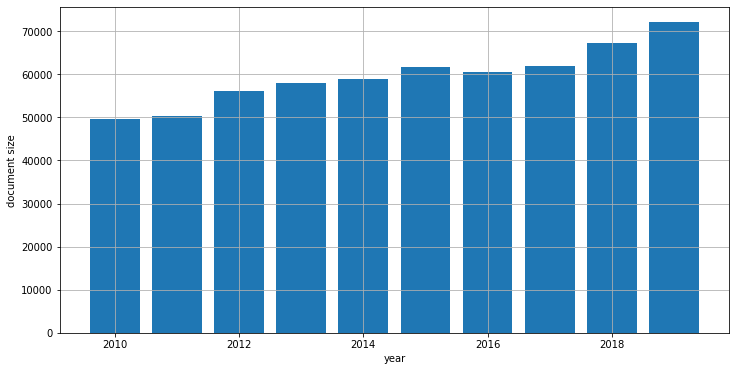

In [165]:
import matplotlib.pyplot as plt

plt.bar(doc_size_by_year.year, doc_size_by_year.document)

plt.xlabel('year')
plt.ylabel('document size')
plt.show()

Similarity_Cohen_Malloy_Nguyen(2019)Lazy Prices의 내용과 마찬가지로 미국 뿐만 아니라 한국에서도 10년간 사업보고서 내의 단어 빈도가 꾸준히 증가하였다. 토큰화된 사업보고서의 텍스트를 기준으로 하였으며 명사로 봤을 때도 단조 증가하는 양상은 동일하였다.

## Sentencepiece

In [9]:
import sentencepiece as spm

In [10]:
str_ls = total_word_count(df.str)

In [11]:
split_strs = [x.split() for x in df.str]

In [12]:
with open("file.txt", 'w',encoding='utf-8') as output:
    for row in split_strs:
        output.write(str(row) + '\n')

In [13]:
with open('file.txt','r',encoding ='utf-8') as f:
    doc = f.read()

In [14]:
spm.SentencePieceTrainer.Train('--input=file.txt --model_prefix=m --vocab_size=391')

RuntimeError: Internal: C:\projects\sentencepiece\src\trainer_interface.cc(427) [(static_cast<int>(required_chars_.size() + meta_pieces_.size())) <= (trainer_spec_.vocab_size())] Vocabulary size is smaller than required_chars. 391 vs 451. Increase vocab_size or decrease character_coverage with --character_coverage option.

In [ ]:
df.str[0].join().replace(",",' ')

In [ ]:
len(doc)

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

In [ ]:
split_strs = [','.join(x).replace(",",' ') for x in df.str]

In [ ]:
print(sp.encode_as_pieces(df.str[0]))

In [ ]:
# from wordcloud import WordCloud #wordcloud 생성
# import matplotlib.pyplot as plt
# import nltk
# from nltk.corpus import stopwords

# %matplotlib inline

# import matplotlib
# from IPython.display import set_matplotlib_formats
# matplotlib.rc('font',family = 'Malgun Gothic')
# set_matplotlib_formats('retina')
# matplotlib.rc('axes',unicode_minus = False)
# plt.rcParams["figure.figsize"] = (15,8)
# wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r",
#             width=1500, height=1000).generate_from_frequencies(nouns_dic) #여기에 dic형태넣어주기

# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show

In [23]:
sum(nouns_dic.values())

1247021